# Загрузим нужные модули

In [30]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import re
import scipy.sparse as sp

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer,  TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV


Загружаем модуль работы с английским языком

Загружаем данные с новостями, где флаг 0 - это настоящие, а 1 - фейковые

In [31]:
nlp = spacy.load('en_core_web_sm')
data_set = pd.read_csv("d:/Downloads/fakenews.csv")
data_set.head()


,text,label
0,Get the latest from TODAY Sign up for our news...,1
1,2d Conan On The Funeral Trump Will Be Invited...,1
2,It’s safe to say that Instagram Stories has fa...,0
3,Much like a certain Amazon goddess with a lass...,0
4,At a time when the perfect outfit is just one ...,0


In [32]:
data_set.info()
data_set['label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4986 entries, 0 to 4985
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4986 non-null   object
 1   label   4986 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.0+ KB


label
0    2972
1    2014
Name: count, dtype: int64

Токенизуруем текст приводим его к нижнему регистру, убираем: пункутуацию, цифры, email, числа и пробелы, а также приводим слова к начальной форме (например, глаголлы к инфинитиву).

In [52]:
data_set['cleaned_text'] = data_set['text'].apply(
    lambda x: ' '.join(
        token.lemma_.lower() for token in nlp(x) if 
            not token.is_stop 
        and not token.is_punct
        and not token.is_digit
        and not token.like_email
        and not token.like_num
        and not token.is_space
        and not token.like_url
        # and not len(re.findall(r"#\w+", token.text))
        and not len(re.findall(r"@\w+", token.text)) # убираю токены типа @login
    )
)

data_set.head()

,text,label,cleaned_text
0,Get the latest from TODAY Sign up for our news...,1,late today sign newsletter truly get lose love...
1,2d Conan On The Funeral Trump Will Be Invited...,1,2d conan funeral trump invite conan tbs
2,It’s safe to say that Instagram Stories has fa...,0,safe instagram stories far surpass competitor ...
3,Much like a certain Amazon goddess with a lass...,0,like certain amazon goddess lasso height direc...
4,At a time when the perfect outfit is just one ...,0,time perfect outfit click away high demand tre...


Создаем тренировочную и тестовую выборки по очищенному тексту

In [53]:
X_train, X_test, y_train, y_test = train_test_split(data_set['cleaned_text'], data_set['label'], random_state=2023)

Проводим векторизацию очищенного текста и обучаем DummyClassifier

In [54]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
pd.DataFrame(X_train_vectorized.toarray(), columns=vectorizer.get_feature_names_out()).head()

,00,000,000000,00113234,00128,00am,00pm,00s,01,018,...,كمان,وأنا,キッズ,女の子,日本語,送料無料,ꮙꭵꭼꮃ,ꮲꮢꭵsꮯꭵꮮꮮꭺ,ﬁnd,𝖅𝖆𝖈𝖍
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_train_vectorized, y_train)
preds = dummy_clf.predict(X_test_vectorized)
print(classification_report(y_test, preds, zero_division=0)) # Стандартные метрики классификации

              precision    recall  f1-score   support

           0       0.57      1.00      0.73       717
           1       0.00      0.00      0.00       530

    accuracy                           0.57      1247
   macro avg       0.29      0.50      0.37      1247
weighted avg       0.33      0.57      0.42      1247



DummyClassifier дает не очень хорошее предсказание переходим к Логистической регрессии

In [56]:
logreg = LogisticRegression(solver='liblinear').fit(X_train_vectorized, y_train)
preds = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.76      0.79      0.78       717
           1       0.70      0.67      0.68       530

    accuracy                           0.74      1247
   macro avg       0.73      0.73      0.73      1247
weighted avg       0.74      0.74      0.74      1247



Проведем векторизацию с учетом отсечения редко и слишкорм часто встречающихся стоп слов типичных этому документу. И применем логистическую регрессию

In [57]:
vectorizer = CountVectorizer(max_df=0.8, min_df=0.001)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

pd.DataFrame(X_train_vectorized.toarray(), columns=vectorizer.get_feature_names_out()).head()

,00,000,00pm,01,02,02am,02pm,03,04,04am,...,zones,zoo,zoom,zoë,zucker,zuma,zylka,ça,édition,überall
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
logreg = LogisticRegression(solver='liblinear').fit(X_train_vectorized, y_train)
preds = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.76      0.79      0.77       717
           1       0.70      0.67      0.68       530

    accuracy                           0.74      1247
   macro avg       0.73      0.73      0.73      1247
weighted avg       0.73      0.74      0.74      1247



Будем использовать только слова с латиницей для векторизации. И также проведем линейну регрессию

In [59]:
def custom_tokenize(text):
  text = re.sub(r'[^a-zA-Z ]', '', text)
  return text.split()

In [60]:
custom_vectorizer = CountVectorizer(
    max_df=0.7, 
    min_df=0.001, 
    tokenizer=custom_tokenize
) 
X_train_vectorized = custom_vectorizer.fit_transform(X_train)
X_test_vectorized = custom_vectorizer.transform(X_test)


pd.DataFrame(X_train_vectorized.toarray(), columns=custom_vectorizer.get_feature_names_out()).head()

c:\Users\yarok\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,a,aa,aaron,ab,ababa,aback,abandon,abandonment,abbey,abbott,...,zoe,zolciak,zombie,zone,zones,zoo,zoom,zucker,zuma,zylka
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,2,0,0,0,0,0,0


In [61]:
logreg = LogisticRegression(solver='liblinear').fit(X_train_vectorized, y_train)
preds = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.76      0.79      0.77       717
           1       0.70      0.66      0.68       530

    accuracy                           0.73      1247
   macro avg       0.73      0.72      0.72      1247
weighted avg       0.73      0.73      0.73      1247



Применем для векторизации подход Tf-Idf с учетом кастомного шаблона токенайзера

In [62]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer(tokenizer=custom_tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression())
    ]
).fit(X_train, y_train)
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))

c:\Users\yarok\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           0       0.74      0.91      0.81       717
           1       0.82      0.56      0.66       530

    accuracy                           0.76      1247
   macro avg       0.78      0.73      0.74      1247
weighted avg       0.77      0.76      0.75      1247



Применем оптимизацию гиперпараметров с помощью HalvingGridSearchCV

In [63]:
parameter_grid = {
    "counter__max_df": np.linspace(0.5, 0.9, 10),
    "counter__min_df": [0.001, 0.003, 0.005],
    "counter__ngram_range": ((1, 1), (1, 2)), # рассматриваем слова или слова и биграммы
    "tfidf__norm": ("l1", "l2"),
    "clf__C": np.linspace(0.1, 1, 10),
}

In [64]:
# %%time

grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy',
    random_state=2023,
    error_score='raise'
)
grid_search.fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 20
max_resources_: 3739
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1200
n_resources: 20
Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
----------
iter: 1
n_candidates: 400
n_resources: 60
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
----------
iter: 2
n_candidates: 134
n_resources: 180
Fitting 5 folds for each of 134 candidates, totalling 670 fits
----------
iter: 3
n_candidates: 45
n_resources: 540
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 4
n_candidates: 15
n_resources: 1620
Fitting 5 folds for each of 15 candidates, totalling 75 fits


c:\Users\yarok\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


HalvingGridSearchCV(error_score='raise',
                    estimator=Pipeline(steps=[('counter',
                                               CountVectorizer(tokenizer=<function custom_tokenize at 0x000001CB8A20B920>)),
                                              ('tfidf', TfidfTransformer()),
                                              ('clf', LogisticRegression())]),
                    n_jobs=-1,
                    param_grid={'clf__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                'counter__max_df': array([0.5       , 0.54444444, 0.58888889, 0.63333333, 0.67777778,
       0.72222222, 0.76666667, 0.81111111, 0.85555556, 0.9       ]),
                                'counter__min_df': [0.001, 0.003, 0.005],
                                'counter__ngram_range': ((1, 1), (1, 2)),
                                'tfidf__norm': ('l1', 'l2')},
                    random_state=2023, scoring='accuracy', verbose=1)

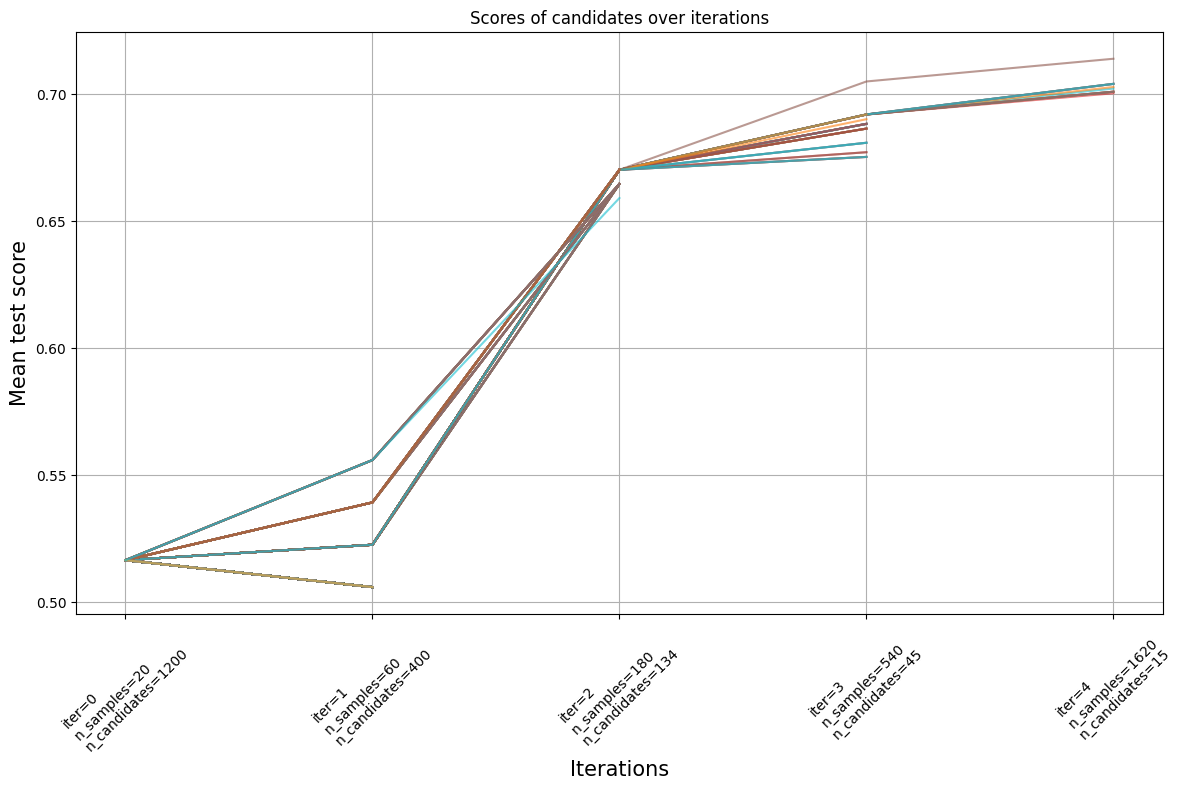

In [65]:
plt.rcParams["figure.figsize"] = (12, 8)
results = pd.DataFrame(grid_search.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", 
    columns="params_str",
     values="mean_test_score",
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={grid_search.n_resources_[i]}\nn_candidates={grid_search.n_candidates_[i]}"
    for i in range(grid_search.n_iterations_)
]

ax.set_xticks(range(grid_search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("Mean test score", fontsize=15)
ax.set_xlabel("Iterations", fontsize=15)
plt.tight_layout()
plt.grid()
plt.show()

In [66]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.73      0.92      0.81       717
           1       0.84      0.54      0.65       530

    accuracy                           0.76      1247
   macro avg       0.78      0.73      0.73      1247
weighted avg       0.77      0.76      0.75      1247



Вывод: с помощью подбора гиперпараметров получилась такая же точность, как и без, однако вырасла вероятность определения фейковых, и немного упала реальных. Возможно требуется болшее глубокое обучения с добавление каких флаг-фековых выражений.